# LDA on Title and Abstract on 91K Research Papers

In [2]:
%load_ext snakeviz

In [2]:
%%time
%matplotlib inline
ROOT_DATA_DIR = "../data/pdf_extract/"
OUTPUT_DIR = "../dataset/"
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaMulticore
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
from multiprocessing import Pool

from nltk import stem

sns.set_style("darkgrid")

CPU times: user 3.72 s, sys: 1.97 s, total: 5.69 s
Wall time: 9.4 s


In [3]:
import pymysql.cursors
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='password123',
                             db='arxivOverload',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
cursor = connection.cursor()
print("Connected with Database")
query = "SELECT arxiv_id, title, abstract FROM arxivOverload.METADATA"
metadata_table_dataframe = pd.read_sql(query, con=connection)

Connected with Database


In [4]:
metadata_table_dataframe.head()

,arxiv_id,title,abstract
0,1802.02569v1,Orbital Transition in the Parent Spin-Orbit Mo...,The crystal lattice and vibrations of Sr2IrO4 ...
1,1802.02559v1,Mechanical Stresses Estimation in Silicon and ...,"During electrostatic bonding, also known as an..."
2,1802.02555v1,Correlations of occupation numbers in the cano...,We study statistical properties of $N$ non-int...
3,1802.02553v1,"Wrinkles, folds and plasticity in granular rafts",We investigate the mechanical response of a co...
4,1802.02552v1,Cracking the Conundrum of F-Supergiant Coronae,Chandra X-ray and HST far-ultraviolet (FUV) ob...


In [5]:
num_partitions = 80 #number of partitions to split dataframe
# num_cores = 1 #number of cores on your machine

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool()
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def encode_df(data):
    data['text'] = data['text'].apply(lambda x: str(x, errors='ignore'))
    return data

def clean_df(df):
    start = time.time()
    print('Process working on: ',os.getpid())
    df['tokenized'] = df['title'].apply(lambda x: apply_all(x)) + df['abstract'].apply(lambda x: apply_all(x))
    print('Process done:',os.getpid())
    print()
    end = time.time()
    print("time to complete :", end-start)
    return df

# For data cleaning 
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", " ", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')

def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = stem.PorterStemmer()

def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [6]:
data = parallelize_dataframe(metadata_table_dataframe, clean_df)

Process working on:  81495
Process working on:  81496
Process working on:  81497
Process working on:  81498
Process done: 81497

time to complete : 11.95574688911438
Process working on:  81497
Process done: 81498

time to complete : 12.438285827636719
Process working on:  81498
Process done: 81495

time to complete : 12.889097929000854
Process working on:  81495
Process done: 81496

time to complete : 12.8612060546875
Process working on:  81496
Process done: 81497

time to complete : 12.325972080230713
Process working on:  81497
Process done: 81498

time to complete : 12.407192945480347
Process working on:  81498
Process done: 81496

time to complete : 12.686558961868286
Process working on:  81496
Process done: 81495

time to complete : 13.135896921157837
Process working on:  81495
Process done: 81498

time to complete : 10.809357166290283
Process working on:  81498
Process done: 81497

time to complete : 12.210772037506104
Process working on:  81497
Process done: 81496

time to comple

In [8]:
data.to_csv("../dataset/DB_tokens.csv", index=False)

In [9]:
# first get a list of all words
all_words = [word for item in list(data['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

83954

In [10]:
k = 300000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('hopper', 39),
 ('conv', 39),
 ('skylin', 39),
 ('soar', 39),
 ('glm', 39),
 ('morton', 39),
 ('iota', 39),
 ('header', 39),
 ('zhu', 39),
 ('kelli', 39)]

In [11]:
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [12]:
data['tokenized'] = data['tokenized'].apply(keep_top_k_words)

In [13]:
len(data['tokenized'])

132330

In [14]:
# document length
data['doc_len'] = data['tokenized'].apply(lambda x: len(x))
doc_lengths = list(data['doc_len'])
data.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 132330 
average document length 99.81187939242803 
minimum document length 4 
maximum document length 317


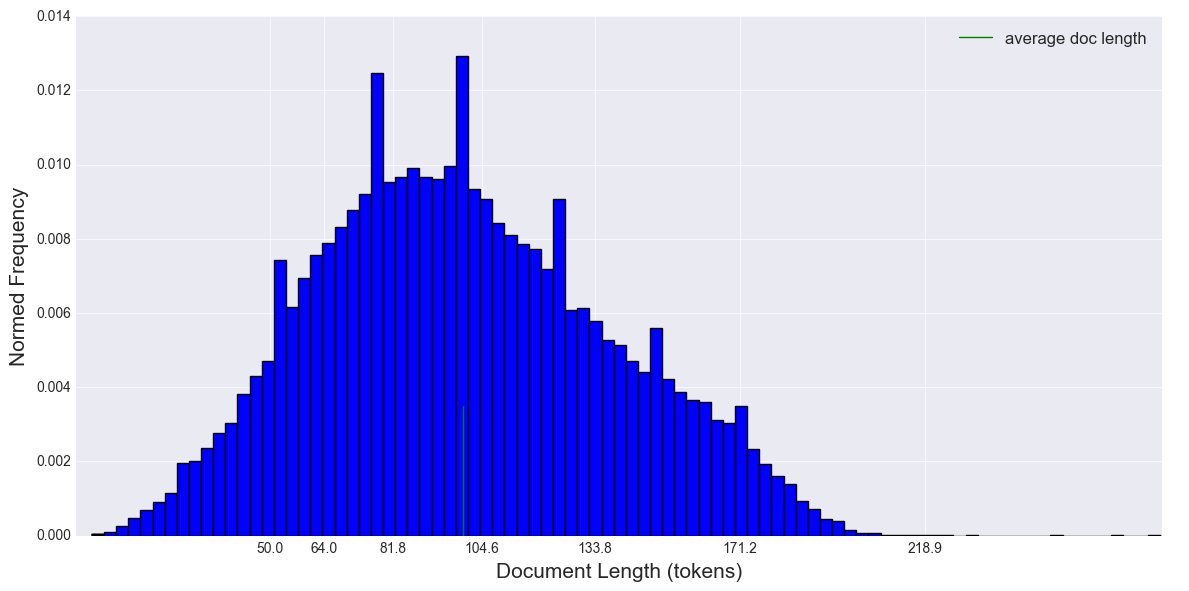

In [15]:
# plot a histogram of document length
num_bins = 100
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(280),num=8, base=10.0))
plt.xlim(0,280)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [16]:
# only keep articles with more than 30 tokens, otherwise too short
data = data[data['tokenized'].map(len) >= 30]
# make sure all tokenized items are lists
data = data[data['tokenized'].map(type) == list]
data.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(data), "articles")

After cleaning and excluding short aticles, the dataframe now has: 130033 articles


In [30]:
msk = np.random.rand(len(data)) > 0.3
train_data = data[msk]
train_data.reset_index(drop=True,inplace=True)

test_data = data[~msk]
test_data.reset_index(drop=True,inplace=True)

In [31]:
print(len(data),len(train_data),len(test_data))

130033 91009 39024


In [32]:
%time
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 30000
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=10, workers = 4)
    t2 = time.time()
    print("Time to train LDA model on ", len(data), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 13.8 µs


In [33]:
dictionary,corpus,lda = train_lda(train_data)

Time to train LDA model on  91009 articles:  15.523566297690074 min


In [56]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_data))
bow = dictionary.doc2bow(train_data.iloc[random_article_index, 3])
print(random_article_index)

34569


In [57]:
print(train_data.iloc[random_article_index,3])

['interfac', 'mediat', 'mechan', 'plastic', 'strain', 'recoveri', 'alloy', 'combin', 'transmiss', 'electron', 'microscopi', 'analysi', 'deform', 'microstructur', 'molecular', 'dynam', 'comput', 'simul', 'deform', 'process', 'mechan', 'plastic', 'strain', 'recoveri', 'bulk', 'either', 'incoher', 'twin', 'cube', 'cube', 'interfac', 'ag', 'cu', 'layer', 'bilay', 'thick', 'nm', 'reveal', 'charact', 'incoher', 'twin', 'interfac', 'chang', 'uniqu', 'dynam', 'compress', 'load', 'sampl', 'exhibit', 'plastic', 'strain', 'recoveri', 'found', 'drive', 'recoveri', 'due', 'disloc', 'retract', 'rearrang', 'interfac', 'magnitud', 'recoveri', 'decreas', 'increas', 'strain', 'disloc', 'tangl', 'disloc', 'cell', 'structur', 'form', 'chang', 'orient', 'relationship', 'found', 'cube', 'cube', 'interfac', 'exhibit', 'lesser', 'amount', 'plastic', 'strain', 'recoveri', 'simul', 'none', 'experiment', 'sampl', 'larger', 'layer', 'thick', 'predominantli', 'cube', 'cube', 'interfac', 'molecular', 'dynam', 'comp

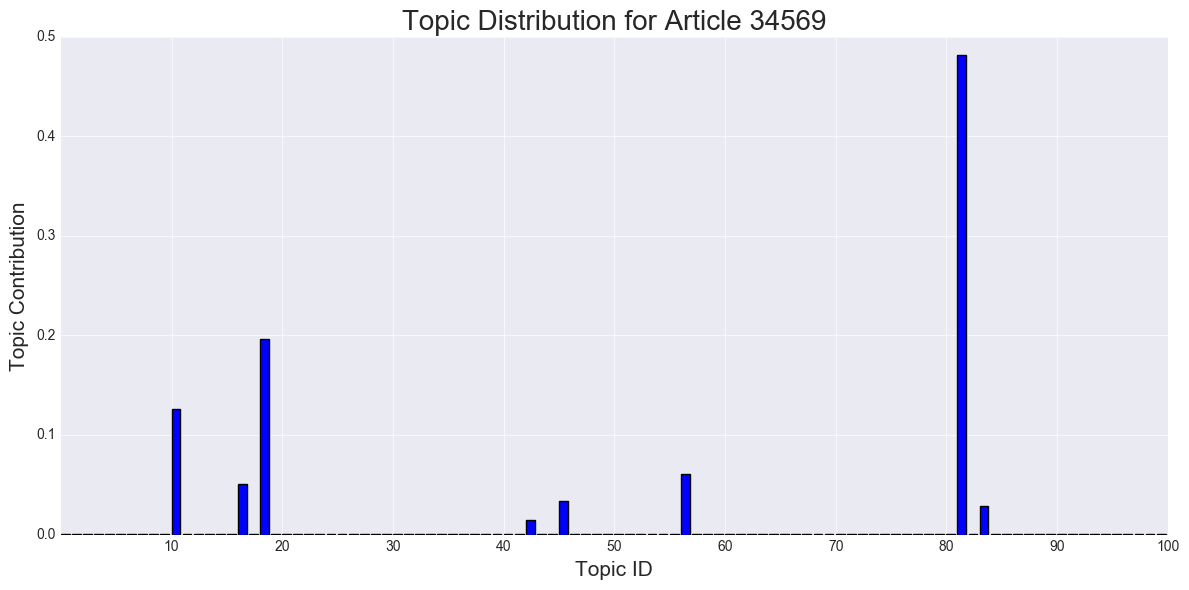

In [61]:
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [68]:
random_article_index = np.random.randint(len(test_data))
print(random_article_index)

20655


In [70]:
bow = dictionary.doc2bow(train_data.iloc[random_article_index, 3])

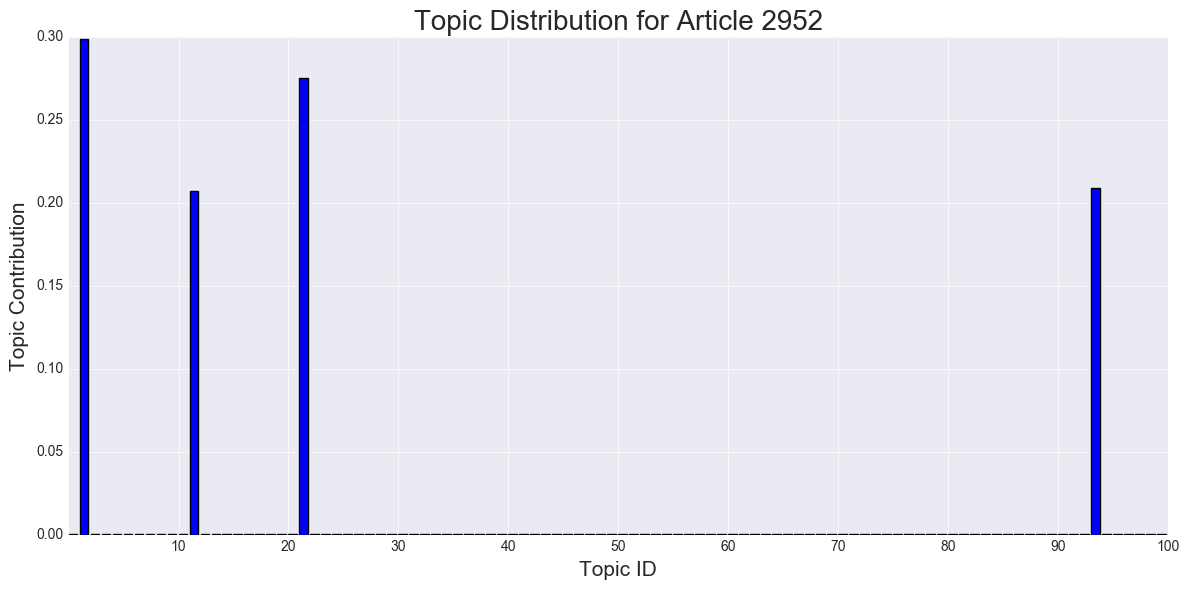

In [81]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [82]:
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

1 [('photon', 0.03858067), ('topolog', 0.02783458), ('coupl', 0.024899378), ('state', 0.02206398), ('caviti', 0.019995103), ('pair', 0.013475728), ('quantum', 0.013275512), ('superconduct', 0.012105052), ('two', 0.01144424), ('system', 0.011175133)] 

21 [('atom', 0.030963412), ('interact', 0.025244579), ('condens', 0.020457763), ('trap', 0.017379766), ('bose', 0.013825754), ('two', 0.013538765), ('ion', 0.0104243215), ('effect', 0.010018337), ('exciton', 0.009915644), ('dynam', 0.009810683)] 

93 [('quantum', 0.12797762), ('state', 0.023277504), ('classic', 0.018161274), ('measur', 0.01810476), ('qubit', 0.015618175), ('system', 0.01184853), ('use', 0.009044697), ('coher', 0.008183925), ('comput', 0.007925074), ('inform', 0.0078097116)] 

11 [('entangl', 0.08563574), ('state', 0.069700286), ('protocol', 0.01878429), ('quantum', 0.014303254), ('two', 0.012580951), ('qubit', 0.012023605), ('measur', 0.010966793), ('use', 0.009772272), ('gener', 0.009652142), ('system', 0.008361831)] 

3

In [74]:
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(91009, 100)

In [75]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [76]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [84]:
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)

In [85]:
most_similar_df = train_data[train_data.index.isin(most_sim_ids)]
most_similar_df['title']

2952     Adiabatic entangling gate of Bose-Einstein con...
5446     Non-adiabatic quantum state preparation and qu...
10267    Adiabatic passage of radiofrequency-assisted F...
29812    Entangling one polariton with a photon: effect...
54086    Measurement-based entanglement of non-interact...
61968    Fusing atomic $W$ states via quantum Zeno dyna...
69049    Polarization entanglement and quantum beats of...
79651    Engineering steady-state entanglement via diss...
79836    Entangling power of holonomic gates in atom-ca...
86072    Entanglement of Atomic Ensembles by Trapping C...
Name: title, dtype: object

# Problem with LDA 

    1. Will not work with > 1TB data 
    2. creates a dense representation of document x number of topic. 
    3. for finding similarity of all the papers and new incoming papers this computation will be extensive adn expensive. 
    4. Hardware limitation.
    